# Infectious Diseases in Continuous Time
We will use simulation of infectious disease spread to help build intuition.

Given the current state of the system, we must first calculate the rates of all possible events.  

- We know that each individual transmits with rate $\beta$ and the transmission is successful with probability $S/N$.  Thus (see self-test exercises) the rate at which infection occurs is $\beta S/N$.  To mimic the continuous-time Galton-Watson process, our accounting treats the individual as if she disappears and is immediately replaced by $2$ infected individuals. 
- Each individual recovers at rate $\gamma$.  


~~~{prf:algorithm} Continuous-Time Infectious Disease Pseudocode
:label: algorithm-ctsTimeInfDis

**Inputs**
```
integer TotalPopSize N
float RecRate =gamma
float TransRate =beta
integer InitialInfCount I(0) #often assumed to be 1, but need not be
float tmax #stopping time
```

**Initialization**
```
S(0)=N-I(0)
t = 0
if SIR:
  R(0)=0
```

**Algorithm**
```
while I>0 and t<tmax:
  TotalRate = (beta S/N + gamma)I$
  WaitingTime = RandomExpVar()
  t = t+ WaitingTime
  with probability (beta IS/N)/TotalRate:   #infection occurs
    I(t) = I+1
    S(t) = S-1
  else:            #recovery occurs
    I(t) = I-1
    if SIS:
      S(t) = S+1
    else:  #SIR 
      R(t) = R+1
```

**Outputs**
```
if SIS:
  return t, S, I 
else:
  return t, S, I, R
~~~
```{prf:remark}
You may notice that the pseudocode above can have its final time greater than `tmax`.  For this reason, the implementation below has an extra step inside the while loop to not record an event if the time is greater than `tmax`.
```

Now we implement this pseudocode in Python.  We will use these methods to simulate SIS and SIR epidemics.

In [ ]:
import numpy as np

def Gillespie_SIR_model(
    S_IC,
    I_IC,
    R_IC,
    beta,
    gamma,
    tmax=float("inf"),
    rng=None
):
    """
    Simulate the SIR model using the Gillespie algorithm.

    Arguments:
    S_IC -- initial susceptible population
    I_IC -- initial infected population
    R_IC -- initial recovered population (not R_0)
    beta -- transmission rate
    gamma -- recovery rate
    tmax -- maximum time to simulate.
    rng -- optional random number generator. If None, a default
           random number generator will be used.


    Returns:
    t -- np array
            time points
    S -- np array
            susceptible population over time
    I -- np array
            infected population over time
    R -- np array
            recovered population over time

    """

    tstart = 0
    if rng is None:
        rng = np.random.default_rng()

    # Initialize populations and time
    N = S_IC + I_IC + R_IC
    S = [S_IC]
    I = [I_IC]
    R = [R_IC]
    t = [tstart]

    while t[-1] < tmax and I[-1] > 0:
        rec_rate = gamma * I[-1]
        inf_rate = beta * S[-1] * I[-1] / N
        total_rate = rec_rate + inf_rate

        delay = rng.exponential(1 / total_rate)

        time = t[-1] + delay
        if time > tmax:
            t.append(tmax)
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            # If there are still infected individuals at tmax, we truncate the simulation and record their data.
            break
        else:
            t.append(time)
            if rng.random() < inf_rate / total_rate:
                # Infection event
                S.append(S[-1] - 1)
                I.append(I[-1] + 1)
                R.append(R[-1])
            else:
                # Recovery event
                S.append(S[-1])
                I.append(I[-1] - 1)
                R.append(R[-1] + 1)

    return np.array(t), np.array(S), np.array(I), np.array(R)

def Gillespie_SIS_model(
    S_IC,
    I_IC,
    beta,
    gamma,
    tmax=float("inf"),
    rng=None
    # the version in AMSI_2026_PGF_tools has additional 
    # arguments allowing it to track cumulative size.
):
    
    """
    Simulate the SIS model using the Gillespie algorithm.

    Arguments:
    S_IC -- initial susceptible population
    I_IC -- initial infected population
    beta -- transmission rate
    gamma -- recovery rate
    tmax -- maximum time to simulate.
    rng -- optional random number generator. If None, a default
           random number generator will be used.


    Returns:
    t -- np array
            time points
    S -- np array
            susceptible population over time
    I -- np array
            infected population over time
    """

    tstart = 0
    if rng is None:
        rng = np.random.default_rng()

    # Initialize populations and time
    N = S_IC + I_IC 
    S = [S_IC]
    I = [I_IC]
    t = [tstart]

    while t[-1] < tmax and I[-1] > 0:
        rec_rate = gamma * I[-1]
        inf_rate = beta * S[-1] * I[-1] / N
        total_rate = rec_rate + inf_rate

        delay = rng.exponential(1 / total_rate)

        time = t[-1] + delay
        if time > tmax:
            t.append(tmax)
            S.append(S[-1])
            I.append(I[-1])
            # If there are still infected individuals at tmax, we truncate the simulation and record their data.
            break
        else:
            t.append(time)
            if rng.random() < inf_rate / total_rate:
                # Infection event
                S.append(S[-1] - 1)
                I.append(I[-1] + 1)
            else:
                # Recovery event
                S.append(S[-1]+1)
                I.append(I[-1] - 1)

    return np.array(t), np.array(S), np.array(I)



## SIS simulations
Let's do some SIS simulations.  As implemented, this will run three simulations and plot them all.  The legend will help distinguish which curves belong together.

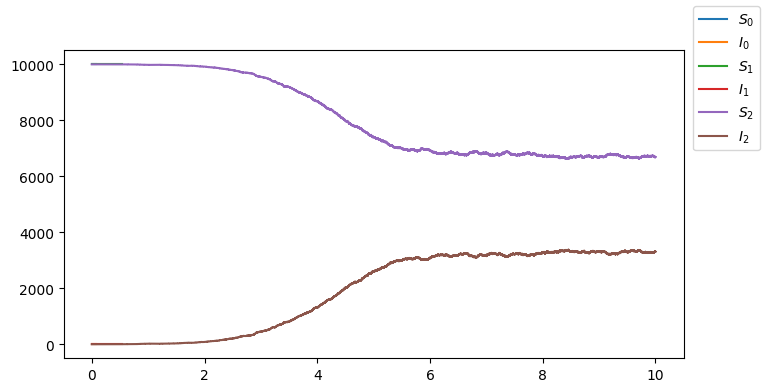

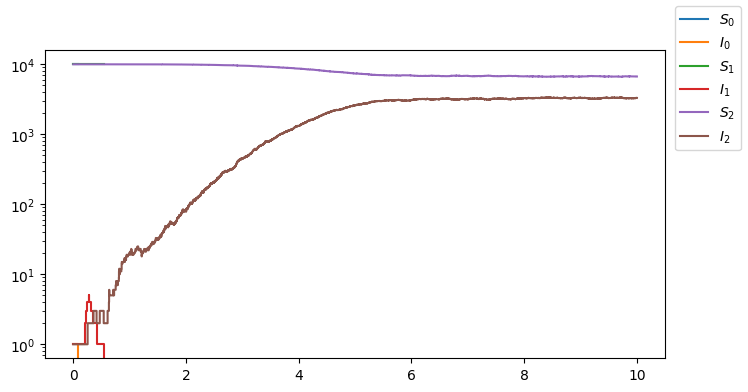

In [10]:
import matplotlib.pyplot as plt

def simulate_and_plot_SIS_dynamics(N, R0=0.9, gammas=(3,), numsims = 3):
    
    fig1 = plt.figure(figsize = (8,4))
    ax1 =plt.gca()
    fig2 = plt.figure(figsize = (8,4))
    ax2 =   plt.gca()
    for gamma in gammas:
        beta = R0 * gamma
        I0 = 1
        for ctr in range(numsims):
            t, S, I = Gillespie_SIS_model(N-I0, I0, beta, gamma, tmax = 10)
            ax1.step(t, S, label='$S_{}$'.format(ctr), where = 'post')
            ax1.step(t, I, label='$I_{}$'.format(ctr), where = 'post')

            ax2.step(t, S, label='$S_{}$'.format(ctr), where = 'post')
            ax2.step(t, I, label='$I_{}$'.format(ctr), where = 'post')
    fig1.legend()
    ax2.set_yscale('log')
    fig2.legend()
    plt.show()

simulate_and_plot_SIS_dynamics(10000, R0=1.5, gammas=(3,), numsims = 3)

Notice that in the simulations that die out quickly, $S$ is always approximately $N$.  In the simulations where an epidemic occurs, there is a long period in which $S$ is approximately $N$.  During this period, there is an initial phase in which $I$ is noisy, but once $I$ is large enough, it grows as a straight line in the log plot.  This suggests exponential growth until $S/N$ is noticeably less than $1$.

## SIR simulations
Now let's look at an SIR version.  One change from the SIS case is that we allow `tmax=`$\infty$.  The simulation is guaranteed to stop because eventually $I(t)$ goes to zero since $S(t)$ decreases monotonically.


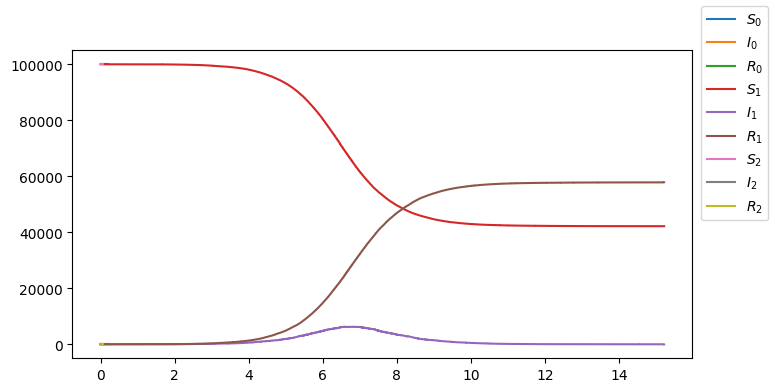

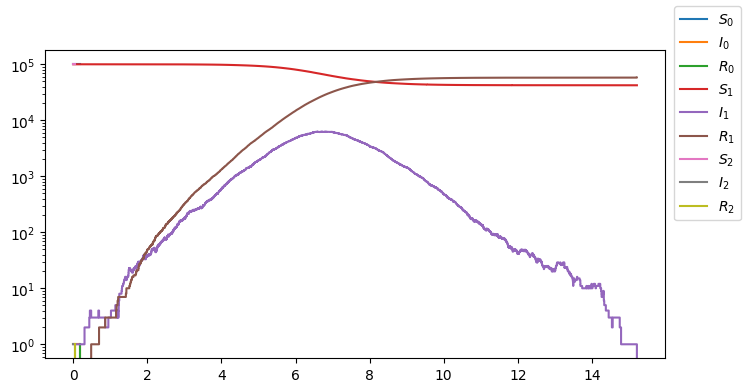

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_and_plot_SIR_dynamics(N, R0=0.9, gammas=(3,), numsims = 3):
    
    fig1 = plt.figure(figsize = (8,4))
    ax1 =plt.gca()
    fig2 = plt.figure(figsize = (8,4))
    ax2 =   plt.gca()
    for gamma in gammas:
        beta = R0 * gamma
        I0 = 1
        for ctr in range(numsims):
            t, S, I, R = Gillespie_SIR_model(N-I0, I0, 0, beta, gamma, tmax = float('inf'))
            ax1.step(t, S, label='$S_{}$'.format(ctr), where = 'post')
            ax1.step(t, I, label='$I_{}$'.format(ctr), where = 'post')
            ax1.step(t, R, label='$R_{}$'.format(ctr), where = 'post')

            ax2.step(t, S, label='$S_{}$'.format(ctr), where = 'post')
            ax2.step(t, I, label='$I_{}$'.format(ctr), where = 'post')
            ax2.step(t, R, label='$R_{}$'.format(ctr), where = 'post')
    fig1.legend()
    ax2.set_yscale('log')
    fig2.legend()
    plt.show()

simulate_and_plot_SIR_dynamics(100000, R0=1.5, gammas=(3,), numsims = 3)

## General behavior of simulations

We see that for both SIS and SIR simulations, many realizations die out, leaving only a small outbreak.  In these realizations, $S/N \approx 1$ for all time.  Thus we expect that these small outbreaks should be consistent with Galton Watson processes.  In the large outbreaks we see that eventually $S/N$ differs from $1$, and so after an initial phase in which the outbreaks are consistent with Galton-Watson proceses (that are growing exponentially), the process begins to differ.

This motivates the definition of small outbrak and epidemic, which we will explore more in the next section.

```{prf:definition} Small outbreak
:label: def-SmallOutbreak
In a large population, we call an outbreak a **small outbreak** if it dies out having only infected a tiny fraction of the entire population.
```
A small outbreak never grows large enough to be significantly affected by the fact that the population size is finite.  Every transmission attempt is successful, but the outbreak dies out because the average infected individual in the realization causes fewer than $1$ transmission. 

```{prf:definition} Epidemic
:label: def-Epidemic
In a large population, we call an outbreak an **epidemic** if it grows large enough to be limited by the population size.
```
An epidemic grows large enough that the size of the affected population is a non-negligible fraction of the entire population.  These stop growing (and in the SIR case decacy) because of depletion of the susceptible population. 

## Self-test
1. Explain why if transmission occurs with rate $\beta$ and is successful with probability $S/N$, then the rate of infection is $\beta S/N$.  [hint, what is the probability that an event has not happened in the time interval $[t_0, t_0+\Delta t)$].

2. The SIS simulations can run indefinitely, so it is important to assign a `tmax`.  However, this is not the case for SIR simulations.  Give a proof that in the SIR case $I(t)$ must eventually go to zero.  The proof should put an upper bound on the total number of successful infections to occur and show that this limits how many events can occur.